In [3]:
!pip install python-graphblas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 1.6 MB/s eta 0:00:00


In [2]:
import graphblas as gb
import pandas as pd
import numpy as np

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector
from graphblas.io import mmread, from_networkx

Проверка

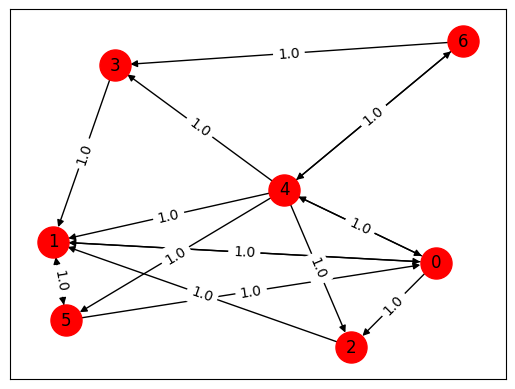

In [3]:
import networkx as nx
new_G = from_networkx(nx.erdos_renyi_graph(7, 0.3, directed=True), dtype='FP32')

gb.viz.draw(new_G)

Теперь - та самая функция page rank, которая считает важность каждой вершины

In [4]:
def pagerank_3f(A, damping=0.85, itermax=100, tol=1e-4):
    '''

    :param A: Заданный граф
    :param damping: трешхолд для телепорта
    :param itermax: максимальное количество итераций
    :param tol:
    :return: Важность каждой вершины и затраченное количество итераций
    '''

    A << A.apply(unary.one)

    # т е для каждой вершины считаем количество элементов в строке (куда есть ребро из этой вершины)
    d_out = A.reduce_rowwise(monoid.plus).new()

    n = A.nrows
    teleport = (1.0 - damping) / n
    rdiff = 1

    # некоторые преобразования для работы функции

    t = Vector(dtypes.FP32, n)
    r = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)
    r[:] << 1.0 / n

    # d = d_out / damping
    d = d_out.dup(dtype="FP32")
    d(accum=binary.truediv)[:] << damping
    for i in range(itermax):
        if rdiff <= tol:
            break
        r, t = t, r
        w << t.ewise_mult(d, binary.truediv)
        r[:] << teleport
        r(binary.plus) << A.T.mxv(w, semiring.plus_second)

        t(binary.minus)[:] << r
        t << t.apply(unary.abs)
        rdiff = t.reduce(monoid.plus).value

    return r, i


In [5]:
result, iters = pagerank_3f(new_G)
result

"v_1"      nvals  size  dtype  format
gb.Vector      7     7   FP32    full
-------------------------------------
index        0         1         2         3         4         5         6
value  0.23587  0.304522  0.102936  0.051451  0.103604  0.165512  0.036106

In [6]:
iters # затраченное количество итераций

11

Проверим также с эталонной реализацией

In [27]:
import networkx as nx

G = gb.io.to_networkx(new_G)
nx.pagerank(G, tol=1e-4)


# ok:

{0: 0.2358745558562038,
 1: 0.3045681796767803,
 2: 0.1029294720365616,
 4: 0.1036009706010559,
 5: 0.16546957495051082,
 3: 0.05145247363123259,
 6: 0.03610477324765486}

Теперь потестируем на разных графах: ну и время конечно тоже потестируем

In [8]:
G1 = from_networkx(nx.erdos_renyi_graph(500, 0.1, directed=True)) # разреженный граф

G2 = from_networkx(nx.erdos_renyi_graph(500, 0.3, directed=True))

G3 = from_networkx(nx.erdos_renyi_graph(500, 0.6, directed=True))

G4 = from_networkx(nx.erdos_renyi_graph(500, 0.9, directed=True)) # почти полнй граф

In [9]:
%timeit nx.pagerank(gb.io.to_networkx(G1), tol=1e-4)
%timeit nx.pagerank(gb.io.to_networkx(G2), tol=1e-4)
%timeit nx.pagerank(gb.io.to_networkx(G3), tol=1e-4)
%timeit nx.pagerank(gb.io.to_networkx(G4), tol=1e-4)

54.3 ms ± 959 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
171 ms ± 35.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
301 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
442 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit pagerank_3f(G1)
%timeit pagerank_3f(G2)
%timeit pagerank_3f(G3)
%timeit pagerank_3f(G4)


# хайпы

4.94 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.77 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.93 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.85 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Наш алгоритм быстрее в 50 раз - круто

Проверка корректности


In [12]:
result_page_rank = pagerank_3f(G1)[0].to_dense()

result_networkx_page_rank = nx.pagerank(gb.io.to_networkx(G1), tol=1e-4)

In [13]:
result_page_rank_dict = {i: result_page_rank[i] for i in range(G1.nrows)}

Чтобы проверить корректность, просуммируем ошибку и поймем, насколько она большая

In [14]:
error_value = sum([abs(result_page_rank_dict[i] - result_networkx_page_rank[i]) for i in range(G1.nrows)])

error_value # ошибка очень небольшая, что говорит о том, что алгоритмы дают по сути одинаковые результаты

np.float32(0.0011710669)

Можно также для отдельных вершин проверить:

In [15]:
print(result_page_rank_dict[0], result_networkx_page_rank[0])
print(result_page_rank_dict[10], result_networkx_page_rank[10])
print(result_page_rank_dict[250], result_networkx_page_rank[250])
print(result_page_rank_dict[378], result_networkx_page_rank[378])

# очень похожие результаты

0.0018043295 0.0018052738776474292
0.0017084649 0.0017093188978958371
0.002306138 0.002303976192582114
0.0021527905 0.0021498169304587176


Для уже существующего графа

In [17]:
G = mmread('blckhole.mtx')

In [18]:
%timeit pagerank_3f(G)
%timeit nx.pagerank(gb.io.to_networkx(G), tol=1e-4)

3.05 ms ± 49.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.5 ms ± 640 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
result_page_rank = pagerank_3f(G)[0].to_dense()

# переведем его в такой же словарь

result_page_rank_dict = {i: result_page_rank[i] for i in range(G.nrows)}

result_networkx_page_rank = nx.pagerank(gb.io.to_networkx(G), tol=1e-4)

In [20]:
print(result_page_rank_dict[0], result_networkx_page_rank[0])
print(result_page_rank_dict[10], result_networkx_page_rank[10])
print(result_page_rank_dict[250], result_networkx_page_rank[250])
print(result_page_rank_dict[378], result_networkx_page_rank[378])


# тоже результаты очень близки

0.00041690315 0.0004215804520682569
0.0004692517 0.00046904315196998124
0.00046904315 0.00046904315196998124
0.00046905855 0.00046904315196998124


Также попробуем повторить реализацию всех параметров

In [21]:
def pagerank_3f_modify(A, damping=0.85, max_iter=100, tol=1e-5, personalization=None,
                       nstart=None, weight='weight', dangling=None):
    '''
    :param dangling:
    :param weight:
    :param nstart:
    :param personalization:
    :param A: Заданный граф
    :param damping: трешхолд для телепорта
    :param max_iter: максимальное количество итераций
    :param tol:
    :return: Важность каждой вершины и затраченное количество итераций
    '''
    W = gb.io.to_networkx(A)
    A << A.apply(unary.one)

    # т е для каждой вершины считаем количество элементов в строке (куда есть ребро из этой вершины)
    d_out = A.reduce_rowwise(monoid.plus).new()

    n = A.nrows
    teleport = (1 - damping) / n
    rdiff = 1

    # некоторые преобразования для работы функции
    t = Vector(dtypes.FP32, n)
    r = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)
    if personalization is None:
        p = {i:1.0/n for i in range(n)}
        r[:] << 1.0 / n
    else:
        s = sum(personalization.values())
        p = {k: v / s for k, v in personalization.items()}
        for k, v in p.items():
            r[k] = v
    d = d_out.dup(dtype="FP32")
    d(accum=binary.truediv)[:] << damping

    if nstart is not None:
        s = sum(nstart.values())
        for k, v in nstart.items():
            r[k] = float(v)/s

    if dangling is None:
        dangling_weights = p
    else:
        s = sum(dangling.values())
        dangling_weights = {k: v / s for k, v in dangling.items()}

    dangling_nodes = [n for n in W if W.out_degree(0, weight=weight) == 0.0]
    for i in range(max_iter):
        if rdiff <= tol:
            break
        r, t = t, r
        w << t.ewise_mult(d, binary.truediv)
        t_to_dense = r.to_dense
        danglesum = damping * sum(t_to_dense[n] for n in dangling_nodes)
        r[:] << danglesum * 1 / n
        for k in p:
            r[k] = p.get(k, 0) * (1 - damping) + danglesum * dangling_weights.get(k, 0)
        for k in dangling_weights:
            r[k] = p.get(k, 0) * (1 - damping) + danglesum * dangling_weights.get(k, 0)
        r(binary.plus) << A.T.mxv(w, semiring.plus_second)

        t(binary.minus)[:] << r
        t << t.apply(unary.abs)
        rdiff = t.reduce(monoid.plus).value

    return r, i

Теперь сравним с настоящей реализацией

In [22]:
f = nx.pagerank(gb.io.to_networkx(G), tol=1e-4, personalization={1:1, 2:2, 3:10},
                nstart={10:10, 52:10}, dangling={20:100, 22:0})

In [23]:
f[1], f[2], f[3], f[11], f[12], f[13]

(0.04757184745071498,
 0.060941013259699486,
 0.16240567491910424,
 0.0004761421523083329,
 0.0033743131868131855,
 0.009875030836510425)

In [24]:
d = pagerank_3f_modify(G, personalization={1:1, 2:2, 3:10})[0].to_dense()


In [25]:
d[1], d[2], d[3], d[11], d[12], d[13]

(np.float32(0.06536443),
 np.float32(0.07704565),
 np.float32(0.17677759),
 np.float32(0.0031987668),
 np.float32(0.005568805),
 np.float32(0.0074113007))

Да; результаты получились очень близкими; personalization работает; также реализован weight, nstart, dangling; но в результатах находил незначительные рассхождения